### (-) 1. Wrap Up method inspection module

### (V) method inspection with filtering constraint (First Parameter as 'Tensor') 

In [417]:
import pkgutil
import inspect
import importlib
import kornia

class LibraryMethodsInspector:
    def __init__(self, library):
        self.library = library

    def find_methods_with_docstrings_image_input(self, module):
        methods_with_docstrings = []
        for name, func in inspect.getmembers(module):
            if inspect.isfunction(func) and func.__doc__:
                sig = inspect.signature(func)
                params = list(sig.parameters.values())
                if params and (params[0].annotation == 'Tensor'or params[0].annotation == torch.Tensor):
                    methods_with_docstrings.append(f"{func.__module__}.{name}")
        return methods_with_docstrings

    def find_submodules(self):
        return [name for _, name, _ in pkgutil.iter_modules(self.library.__path__)]

    def inspect(self):
        methods_dict = {}
        submodules = self.find_submodules()
        for submodule in submodules:
            module = importlib.import_module(f"{self.library.__name__}.{submodule}")
            methods = self.find_methods_with_docstrings_image_input(module)
            if methods:
                methods_dict[submodule] = methods
        return methods_dict

inspector = LibraryMethodsInspector(kornia)
methods_list = inspector.inspect()
print(methods_list)

{'color': ['kornia.color.colormap.apply_colormap', 'kornia.color.gray.bgr_to_grayscale', 'kornia.color.rgb.bgr_to_rgb', 'kornia.color.rgb.bgr_to_rgba', 'kornia.color.gray.grayscale_to_rgb', 'kornia.color.hls.hls_to_rgb', 'kornia.color.hsv.hsv_to_rgb', 'kornia.color.lab.lab_to_rgb', 'kornia.color.rgb.linear_rgb_to_rgb', 'kornia.color.luv.luv_to_rgb', 'kornia.color.raw.raw_to_rgb', 'kornia.color.raw.raw_to_rgb_2x2_downscaled', 'kornia.color.rgb.rgb_to_bgr', 'kornia.color.gray.rgb_to_grayscale', 'kornia.color.hls.rgb_to_hls', 'kornia.color.hsv.rgb_to_hsv', 'kornia.color.lab.rgb_to_lab', 'kornia.color.rgb.rgb_to_linear_rgb', 'kornia.color.luv.rgb_to_luv', 'kornia.color.raw.rgb_to_raw', 'kornia.color.rgb.rgb_to_rgba', 'kornia.color.xyz.rgb_to_xyz', 'kornia.color.ycbcr.rgb_to_y', 'kornia.color.ycbcr.rgb_to_ycbcr', 'kornia.color.yuv.rgb_to_yuv', 'kornia.color.yuv.rgb_to_yuv420', 'kornia.color.yuv.rgb_to_yuv422', 'kornia.color.rgb.rgba_to_bgr', 'kornia.color.rgb.rgba_to_rgb', 'kornia.color.sep

### (v) 1. Wrap up Library Inspect Module, Add `None case` for method that is not correctly defined in inspecting module

In [406]:
import inspect
import importlib

class InputInfo:
    def __init__(self, name, annotation, default):
        self.name = name
        self.annotation = annotation
        self.default = default

    def getName(self):
        return self.name

    def getType(self):
        type_annotation = str(self.annotation)
        if type_annotation.startswith("<class '"):
            type_annotation = type_annotation[8:-2]  # Remove "<class '" and "'>"
        if self.checkMultiDatatypes():
            # If so, keep the second datatype
            return type_annotation.split('|')[1].strip()
        else:
            return type_annotation

    def checkMultiDatatypes(self):
        # Check if this input has multiple datatypes by checking the '|' in annotation
        return '|' in str(self.annotation)

    def isRequired(self):
        # If a parameter has a default value, it's optional. Otherwise, it's required.
        return self.default is inspect.Parameter.empty

class OpInfo:
    def __init__(self, method_str):
        self.full_name = method_str
        module_str, method_str = method_str.rsplit('.', 1)
        self.module_path = module_str
        self.module = importlib.import_module(module_str)
        try:
            self.method = getattr(self.module, method_str)
        except AttributeError:
            self.method = None
            self.signature = None
            return
        self.signature = inspect.signature(self.method)

    def getName(self):
        return self.method.__name__ if self.method else None

    def getFullName(self):
        return self.full_name

    def getModulePath(self):
        return self.module_path 

    def getLibraryName(self):
        return self.full_name.split('.')[0]
        
    def inputs(self):
        if not self.signature:
            return None
        parameters = self.signature.parameters
        return {name: InputInfo(name, str(param.annotation), param.default) for name, param in parameters.items()}

    def outputs(self):
        if not self.signature:
            return None
        return_annotation = str(self.signature.return_annotation)
        if return_annotation.startswith("<class '"):
            return_annotation = return_annotation[8:-2]  # Remove "<class '" and "'>"
        return return_annotation

    def __str__(self):
        if not self.method:
            return f"Method not found for {self.full_name}"
        result = f"Library Name: {self.getLibraryName()}\n"
        result += f"Simple Name: {self.getName()}\n"
        result += f"Full Name: {self.getFullName()}\n"
        result += f"Module Path: {self.getModulePath()}\n"
        inputs = self.inputs()
        if inputs:
            for name, input in inputs.items():
                result += f"Input: {name}, Type: {input.getType()}, Required: {input.isRequired()}\n"
        result += f"Outputs: {self.outputs()}"
        return result

# Usage
max_blur_pool2d_op_info = OpInfo('kornia.filters.max_blur_pool2d')
print(max_blur_pool2d_op_info)

color_sepia = OpInfo('kornia.color.sepia.sepia')
print(color_sepia)


Library Name: kornia
Simple Name: max_blur_pool2d
Full Name: kornia.filters.max_blur_pool2d
Module Path: kornia.filters
Input: input, Type: Tensor, Required: True
Input: kernel_size, Type: int, Required: True
Input: stride, Type: int, Required: False
Input: max_pool_size, Type: int, Required: False
Input: ceil_mode, Type: bool, Required: False
Outputs: Tensor
Method not found for kornia.color.sepia.sepia


### 2. Modify Code Snippet Generator

In [63]:
### test modules
def import_part(op_info):
    import_code = f"import {op_info.getLibraryName()}\n"
    import_code += f"from {op_info.getModulePath()} import {op_info.getName()}\n"
    return import_code
print(import_part(median_blur_op_info))


import kornia
from kornia.filters import median_blur



### CodeSnippetGenerator_Python

In [413]:
import textwrap
class CodeSnippetGenerator_Python:
    def __init__(self, op_info, mapping_dict):
        self.op_info = op_info
        self.mapping_dict = mapping_dict
        self.code_snippet = self.generate_code_snippet() 
        
    def import_part(self,op_info):
        import_code = f"import {op_info.getLibraryName()}\n"
        import_code += f"from {op_info.getModulePath()} import {op_info.getName()}\n"
        display_required_imports = "import torch\nimport torchvision.transforms as transforms\nfrom PIL import Image\nimport matplotlib.pyplot as plt\n"
        import_code += display_required_imports
        return import_code

    def get_input_image(self):
        return "#Get input image\nvp_input_image = n_1_image\ninput = vp_input_image.get('value')\n"
        
    def op_calling_and_running(self,op_info):  
        method_name = op_info.getName()
        args = []
        code = f'result_image = {method_name}('
        for input in op_info.inputs().values():
            if input.isRequired():
                    args.append(input.getName())
        # Join the arguments with ', ' and add them to the function call
        code += ', '.join(args) + ')\n'
        return code
    
    def display_image_information(self, op_info):
        node_name = op_info.getName()
        display_code = '''\
        def image_info(image):
            print("--- After {} ---")
            # Remove the batch dimension and convert the tensor to an image
            image = transforms.ToPILImage()(image.squeeze(0))
            # Display the image
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            print ("--------------------------------")
        image_info(result_image);
    '''.format(node_name)
        return textwrap.dedent(display_code)
        
    def add_metadata_for_output(self,op_info,mapping_dict):
        output_datatype= op_info.outputs()
        if mapping_dict.get(output_datatype) and "datatype" in mapping_dict[output_datatype]: 
            output_datatype = mapping_dict[output_datatype]["datatype"]
        metadata_code = '''\
            result_image = {{
              'value': result_image,
              'dataType': '{}',
              'metadata': {{
                'colorChannel': 'rgb',
                'channelOrder': 'channelLast',
                'isMiniBatched': False,
                'intensityRange': '0-255',
                'device': 'cpu'
              }}
            }}
        '''.format(output_datatype)
        return textwrap.dedent(metadata_code)


    def generate_code_snippet(self):
        """
        Generate a code snippet for the given operation name and mapping dictionary.
        
        Parameters:
        op_name (str): The name of the operation.
        mapping_dict (dict): The mapping dictionary.
    
        Returns:
        str: The generated code snippet.
        """
        if self.op_info is None or op_info.method is None:
            code_snippet = None
        else:
            code_snippet = self.import_part(self.op_info)
            code_snippet += self.get_input_image()
            code_snippet += self.op_calling_and_running(self.op_info)
            code_snippet += self.display_image_information(self.op_info)
            code_snippet += self.add_metadata_for_output(self.op_info,self.mapping_dict)
            
        return code_snippet
        
    def __str__(self):
        return self.code_snippet
        
code_snippet_generator = CodeSnippetGenerator_Python(max_blur_pool2d_op_info, mapping_dict)
print(code_snippet_generator)

import kornia
from kornia.filters import max_blur_pool2d
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
#Get input image
vp_input_image = n_1_image
input = vp_input_image.get('value')
result_image = max_blur_pool2d(input, kernel_size)
def image_info(image):
    print("--- After max_blur_pool2d ---")
    # Remove the batch dimension and convert the tensor to an image
    image = transforms.ToPILImage()(image.squeeze(0))
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print ("--------------------------------")
image_info(result_image);
result_image = {
  'value': result_image,
  'dataType': 'Tensor',
  'metadata': {
    'colorChannel': 'rgb',
    'channelOrder': 'channelLast',
    'isMiniBatched': False,
    'intensityRange': '0-255',
    'device': 'cpu'
  }
}



--- After max_blur_pool2d ---


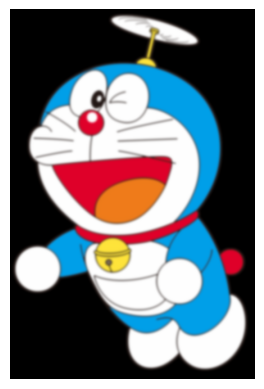

--------------------------------


In [158]:
import kornia
from kornia.filters import max_blur_pool2d
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- 
# Load the image using PIL
img = Image.open("doraemon.png")

# Convert the image to a tensor and add a batch dimension
transform = transforms.ToTensor()
x_rgb = transform(img).unsqueeze(0)  # BxCxHxW

# Check if the image has an alpha channel and discard it if it does
if x_rgb.shape[1] == 4:
    x_rgb = x_rgb[:, :3, ...]

# ----

result_image = max_blur_pool2d(x_rgb, 30)
def image_info(image):
    print("--- After max_blur_pool2d ---")
    # Remove the batch dimension and convert the tensor to an image
    image = transforms.ToPILImage()(image.squeeze(0))
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print ("--------------------------------")
image_info(result_image);
result_image = {
  'value': result_image,
  'dataType': 'torch.tensor',
  'metadata': {
    'colorChannel': 'grayscale',
    'channelOrder': 'channelLast',
    'isMiniBatched': False,
    'intensityRange': '0-255',
    'device': 'cpu'
  }
}

### Node Specification Generation for Python Library

--- Original Image: ---


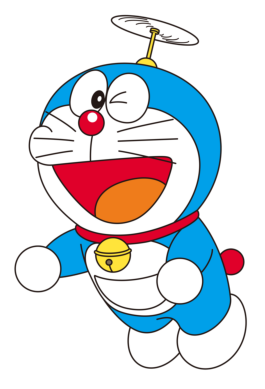

--------------------------------
--- After box_blur ---


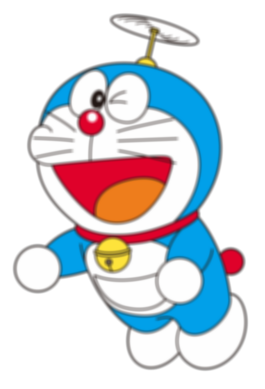

--------------------------------
--- After max_blur_pool2d ---


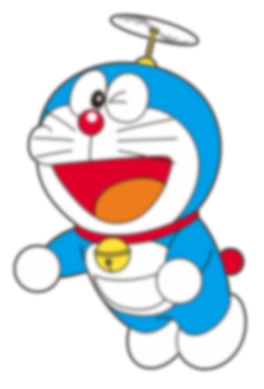

--------------------------------


In [428]:
{"nodes":[{"id":"0","type":"Flow Control.main","position":{"x":154.81939697265625,"y":116.90277099609375},"outputs":{"execOut":{"dataType":"exec"}},"title":"main"},{"id":"1","type":"rgb2Tensor.rgb2Tensor","position":{"x":280.08005480410986,"y":112.14619482066308},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"path","value":"doraemon.png","dataType":"string"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"rgb2Tensor"},{"id":"2","type":"kornia_Package.filters.box_blur","position":{"x":606.7081872182197,"y":95.8147881999576},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"image","value":{"dataType":"torch.tensor","metadata":[{"colorChannel":"rgb","isMiniBatched":false,"channelOrder":"channelLast","intensityRange":["0-255"],"device":["cpu"]}]},"dataType":"image"},"kernel_size":{"title":"kernel_size","value":10,"dataType":"integer"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"box_blur"},{"id":"3","type":"kornia_Package.filters.max_blur_pool2d","position":{"x":949.6677262530352,"y":111.10930186992289},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"image","value":{"dataType":"torch.tensor","metadata":[{"colorChannel":"rgb","isMiniBatched":false,"channelOrder":"channelLast","intensityRange":["0-255"],"device":["cpu"]}]},"dataType":"image"},"kernel_size":{"title":"kernel_size","value":50,"dataType":"integer"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"max_blur_pool2d"}],"edges":[{"id":"reactflow__edge-0execOut-1execIn","output":"0","input":"1","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-1execOut-2execIn","output":"1","input":"2","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-1output_image-2input_image","output":"1","input":"2","outputHandle":"output_image","inputHandle":"input_image","dataType":"image","style":{"strokeWidth":2,"stroke":"hsl(300, 200%, 25%)"}},{"id":"reactflow__edge-2execOut-3execIn","output":"2","input":"3","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-2output_image-3input_image","output":"2","input":"3","outputHandle":"output_image","inputHandle":"input_image","dataType":"image","style":{"strokeWidth":2,"stroke":"hsl(300, 200%, 25%)"}}]}

In [349]:
class NodeSpecGeneration_Python:
    
    def __init__(self, op_info, type_mapping_table_file):
            self.op_info = op_info
            self.op_name = str(op_info.getName()).replace('.', '_')
            self.type_mapping_table_file = type_mapping_table_file
            self.mapping_dict = self.mapping_xlsx_to_mapping_dict(self.type_mapping_table_file)
            self.code_snippet = CodeSnippetGenerator_Python(self.op_info, mapping_dict).code_snippet

    def get_node_json_template(self):
        node_json_template = {"Op_name": {
                    "type": "Op_name",
                    "category": "function",
                    "title": "Op_name",
                    "tooltip": "This is node tooltip",
                    "externalImports": " ",
                    "codeGenerator": "function code(inputs, outputs, node, generator) {\n  const code = ` `\n;\n  return code;\n}",
                    "inputs": {
                        "execIn": {
                            "title": "execIn",
                            "tooltip": "execIn",
                            "dataType": "exec",
                            "showWidget": False,
                            "showTitle": False
                        },
                        "input_image": {
                            "title": "image",
                            "dataType": "image",
                            "defaultValue": {
                                "dataType": "torch.tensor",
                                "metadata": [
                                    {
                                        "colorChannel": "rgb",
                                        "isMiniBatched": False,
                                        "channelOrder": "channelLast",
                                        "intensityRange": [
                                            "0-255"
                                        ],
                                        "device": [
                                            "cpu"
                                        ]
                                    }
                                ]
                            },
                            "tooltip": "input image."
                        },
                    },
                    "outputs": {
                        "execOut": {
                            "title": "execOut",
                            "tooltip": "execOut",
                            "dataType": "exec",
                            "showWidget": False,
                            "showTitle": False
                        },
                        "output_image": {
                            "title": "image",
                            "dataType": "image",
                            "defaultValue": {
                                "dataType": "torch.tensor"
                            },
                            "tooltip": "{dataType: torch.tensor, value, layout: [chw], colorMode: [rgb, grayscale], intensityRange: 0-255' device: cpu}"
                        }
                    }
                }
            }
        return node_json_template
    
    def update_op_name(self, op_name, node_json_template):
        updated_json = copy.deepcopy(node_json_template)
        if 'Op_name' in updated_json:
            updated_json[op_name] = updated_json.pop('Op_name')
            updated_json[op_name]['type'] = op_name
            updated_json[op_name]['title'] = op_name
        else:
            print("There's no Op_name in your node_template, please check again")
        return updated_json
    
    def extract_and_remove_imports(self, code_snippet):
        parsed_code = ast.parse(code_snippet)
        imports = []
        for node in parsed_code.body:
            if isinstance(node, ast.Import):
                for alias in node.names:
                    name = alias.name
                    asname = ' as ' + alias.asname if alias.asname else ''
                    imports.append(f"import {name}{asname}")
            elif isinstance(node, ast.ImportFrom): 
                for alias in node.names:
                    name = alias.name
                    asname = ' as ' + alias.asname if alias.asname else ''
                    imports.append(f"from {node.module} import {name}{asname}")
        # Remove the extracted imports from the original code snippet
        for import_statement in imports:
            code_snippet = code_snippet.replace(import_statement, '', 1)
        return imports, code_snippet.strip()

    def update_external_imports(self, node_json_template, op_name, extracted_imports):
        updated_json = copy.deepcopy(node_json_template)      
        if op_name in updated_json:
            updated_imports = '\n'.join(extracted_imports)
            updated_json[op_name]['externalImports'] = updated_imports
        else:
            print(f"There's no {op_name} in your node_template, please check again")
        return updated_json

    def get_format_parameters(self,opInfo):
        needed_input_name = ["n_1_image"]
        needed_output_name = "result_image"
        for input in opInfo.inputs().values():
            if input.isRequired() and input.getName() != 'input':
                needed_input_name.append(input.getName())
        return needed_output_name, needed_input_name    
        
    def format_code_with_unknown_input_number(self, code, output1, *args):
        code_copy = code[:]
        # Replace the output name in the code
        code_copy = code_copy.replace(output1, "${outputs[1]}")
        # Replace the input names in the code
        for i, arg in enumerate(args, start=1):
            code_copy = code_copy.replace(arg, f"${{inputs[{i}]}}")
        # Add a visible '\n' at the end of each line
        code_copy = '\\n'.join(code_copy.strip().splitlines()) + '\\n'
        code_copy += '${outputs[0]}'
        # Add backticks at the beginning and end of the code
        code_copy = '`' + code_copy + '`'  
        codeGenerator = f"""function code(inputs, outputs, node, generator) {{
          const code = {code_copy};
          return code;
        }}"""
        return codeGenerator

    def update_code_generator(self, node_json_template, op_name, extracted_code_generator):
        updated_json = copy.deepcopy(node_json_template)
        if op_name in updated_json:
            updated_json[op_name]['codeGenerator'] = extracted_code_generator
        else:
            print(f"There's no {op_name} in your node_template, please check again")
        return updated_json
        
    def get_op_required_parameters(self,op_info):
        para_dict = {}
        for input in op_info.inputs().values():
            if input.isRequired():
                current_input_type = str(input.getType())
                para_dict[input.getName()] = current_input_type
        return para_dict
        
    def mapping_datatype(self, para_dict, mapping_dict):
        mapped_parameters = {}
        for key, value in para_dict.items():
            if value in mapping_dict:
                mapped_parameters[key] = mapping_dict[value]['datatype']
            else:
                mapped_parameters[key] = value
        return mapped_parameters

    def update_inputs_info(self,node_json_template, mapped_parameters):
        updated_json = copy.deepcopy(node_json_template)
        items = list(mapped_parameters.items())[1:]  #skip the first input image parameter
        for param,datatype in items:
            updated_json[self.op_name]['inputs'][param] = {
                "title": param,
                "dataType": datatype,
                "tooltip": f"This is {param} tooltip"
                }
        return updated_json
    
    def mapping_xlsx_to_mapping_dict(self, file_path):
        df = pd.read_excel(file_path,index_col = 0)
        data_dict = df.to_dict('index')
        return data_dict
    
    def print_json(self,json_data):
        print(json.dumps(json_data, indent=4))

    def print_mapping_dict(self,mapping_dict):
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(mapping_dict)
    
    def run(self):
        node_json_template = self.get_node_json_template()
        updated_json = self.update_op_name(self.op_name, node_json_template)
        extracted_imports, code_snippet_without_imports = self.extract_and_remove_imports(self.code_snippet)
        updated_json = self.update_external_imports(updated_json, self.op_name, extracted_imports)
        op_required_parameters = self.get_op_required_parameters(self.op_info)
        mapped_parameters= self.mapping_datatype(op_required_parameters,self.mapping_dict)
        mapping_dict = self.mapping_xlsx_to_mapping_dict(self.type_mapping_table_file)
        updated_json= self.update_inputs_info(updated_json, mapped_parameters)
        self.needed_output_name, self.needed_input_name = self.get_format_parameters(self.op_info)
        formated_code_for_codeGenerator = self.format_code_with_unknown_input_number(code_snippet_without_imports, self.needed_output_name, *self.needed_input_name)
        updated_json = self.update_code_generator(updated_json, self.op_name, formated_code_for_codeGenerator)
        return updated_json
        


### Final Run

In [429]:
def generate_node_specs_python(library, type_mapping_table_file):
    import os
    final_json = {
        "description": "This is package description",
        "enable": True,
        "nodes": {}
    }
    methods_list = LibraryMethodsInspector(library).inspect()
    dir_name = f"{str(library.__name__)}_Package"
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    for namespace,methods in methods_list.items():
        for method in methods:
            op_info = OpInfo(method)
            if op_info is None or op_info.method is None:
                continue
            else:
                node_spec_generator = NodeSpecGeneration_Python(op_info, type_mapping_table_file)
                node_spec_json = node_spec_generator.run()
                final_json["nodes"].update(node_spec_json)
        # Save each namespace to a separate JSON file
        with open(os.path.join(dir_name, f'{namespace}.json'), 'w') as f:
            json.dump(final_json, f, indent=4)
            print(f"{namespace}.json has been saved in {dir_name} folder.")
        final_json["nodes"].clear()
    init_json = {
        "description": "Kornia is a framework for reusable image processing operations.",
        "enable": True
    }
    with open(os.path.join(dir_name, '__init__.json'), 'w') as f:
        json.dump(init_json, f, indent=4)
        print("__init__.json has been saved in {} folder.".format(dir_name))
         
type_mapping_table_file = 'mapping_table_kornia.xlsx'
generate_node_specs_python(kornia,type_mapping_table_file)

color.json has been saved in kornia_Package folder.
contrib.json has been saved in kornia_Package folder.
core.json has been saved in kornia_Package folder.
enhance.json has been saved in kornia_Package folder.
feature.json has been saved in kornia_Package folder.
filters.json has been saved in kornia_Package folder.
geometry.json has been saved in kornia_Package folder.
losses.json has been saved in kornia_Package folder.
metrics.json has been saved in kornia_Package folder.
morphology.json has been saved in kornia_Package folder.
testing.json has been saved in kornia_Package folder.
utils.json has been saved in kornia_Package folder.
__init__.json has been saved in kornia_Package folder.


--- Original Image: ---


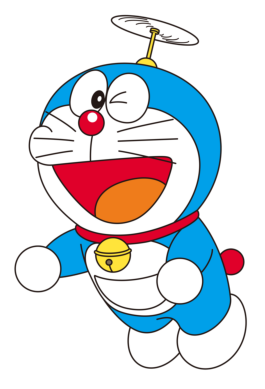

--------------------------------
--- After box_blur ---


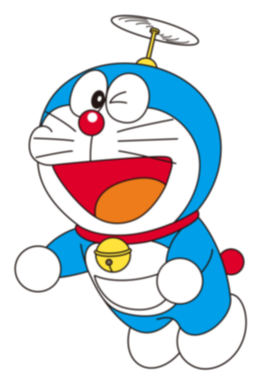

--------------------------------
--- After max_blur_pool2d ---


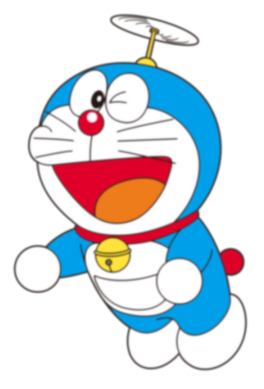

--------------------------------


In [430]:
{"nodes":[{"id":"0","type":"Flow Control.main","position":{"x":196.81939697265625,"y":55.78814697265625},"outputs":{"execOut":{"dataType":"exec"}},"title":"main"},{"id":"1","type":"rgb2Tensor.rgb2Tensor","position":{"x":312.81939697265625,"y":42.78814697265625},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"path","value":"doraemon.png","dataType":"string"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"rgb2Tensor"},{"id":"2","type":"kornia_Package.filters.box_blur","position":{"x":627.8193969726562,"y":57.121490478515625},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"image","value":{"dataType":"torch.tensor","metadata":[{"colorChannel":"rgb","isMiniBatched":false,"channelOrder":"channelLast","intensityRange":["0-255"],"device":["cpu"]}]},"dataType":"image"},"kernel_size":{"title":"kernel_size","value":5,"dataType":"integer"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"box_blur"},{"id":"3","type":"kornia_Package.filters.max_blur_pool2d","position":{"x":948.8193969726562,"y":61.121490478515625},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"image","value":{"dataType":"torch.tensor","metadata":[{"colorChannel":"rgb","isMiniBatched":false,"channelOrder":"channelLast","intensityRange":["0-255"],"device":["cpu"]}]},"dataType":"image"},"kernel_size":{"title":"kernel_size","value":10,"dataType":"integer"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"max_blur_pool2d"}],"edges":[{"id":"reactflow__edge-0execOut-1execIn","output":"0","input":"1","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-1execOut-2execIn","output":"1","input":"2","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-1output_image-2input_image","output":"1","input":"2","outputHandle":"output_image","inputHandle":"input_image","dataType":"image","style":{"strokeWidth":2,"stroke":"hsl(300, 200%, 25%)"}},{"id":"reactflow__edge-2execOut-3execIn","output":"2","input":"3","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-2output_image-3input_image","output":"2","input":"3","outputHandle":"output_image","inputHandle":"input_image","dataType":"image","style":{"strokeWidth":2,"stroke":"hsl(300, 200%, 25%)"}}]}